1


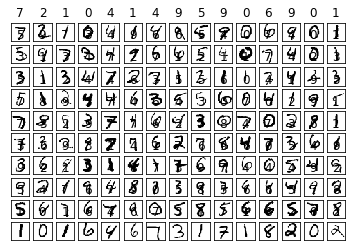

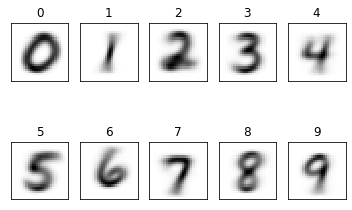

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:195: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


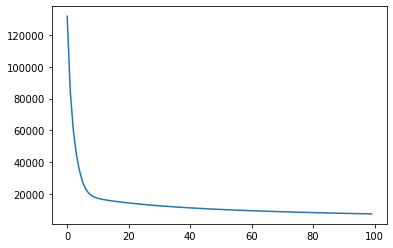

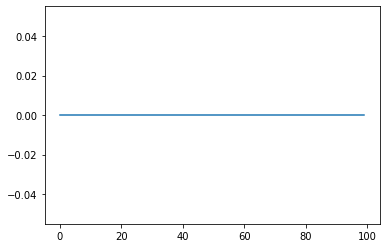

In [3]:
import matplotlib.pyplot as plt
import numpy as np

print(1)

file_data   = "mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# example of distance function between two vectors x and y
#
def distance(x, y):

    d = (x - y) ** 2
    s = np.sum(d)
    # r = np.sqrt(s)

    return(s)

#
# make a matrix each column of which represents an images in a vector form
#
list_image  = np.empty((size_row * size_col, num_image), dtype=float)
list_label  = np.empty(num_image, dtype=int)

for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    list_label[count]       = label
    list_image[:, count]    = im_vector

    count += 1

#
# plot first 150 images out of 10,000 with their labels
#
f1 = plt.figure(1)

for i in range(150):

    label       = list_label[i]
    im_vector   = list_image[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    plt.subplot(10, 15, i+1)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)


#plt.show()

#
# plot the average image of all the images for each digit
#
f2 = plt.figure(2)

im_average  = np.zeros((size_row * size_col, 10), dtype=float)
im_count    = np.zeros(10, dtype=int)

for i in range(num_image):

    im_average[:, list_label[i]] += list_image[:, i]
    im_count[list_label[i]] += 1

for i in range(10):

    im_average[:, i] /= im_count[i]

    plt.subplot(2, 5, i+1)
    plt.title(i)
    plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

plt.show()

### Definition of Class and Functions
class NeuralNetwork(object):
    def __init__(self,alpha,iteration,l2):
        self.alpha = alpha
        self.iteration = iteration
        self.l2=l2
    
    def _onehot(self,label,n_classes):
        onehot = np.zeros((n_classes,label.shape[0]))
        for i, val in enumerate(label.astype(int)):
            onehot[val,i] = 1
        return onehot.T #10,000 rows, 10 cols
    
    def _sigmoid(self,z):
        return 1/(1+np.exp(-z))
    
    def _activate(self,z):
        return self._sigmoid(z)
    
    def _jumpLayer(self,X,u,b):
        y = np.dot(X,u) + b
        return self._activate(y)
    
    def _forward(self,X): #정방향 계산
        y_a = self._jumpLayer(X,self.u,self.ub) #y의 활성화
        z_a = self._jumpLayer(y_a,self.v,self.vb) #z의 활성화
        h_a = self._jumpLayer(z_a,self.w,self.wb) #h의 활성화
        return y_a,z_a,h_a
    
    
    def _cost(self,label,output):
        term1 = (-label*np.log(output))
        term2 = (1-label)*np.log(1.-output)
        cost = np.sum(term1 - term2)
        return cost
    
    def predict(self,X):
        y_a,z_a,h_a = self._forward(X)
        l_predicted = np.argmax(h_a)
        return l_predicted
    
    def fit(self,X_train,l_train,X_test,l_test):        
        
        self.cost = []
        self.accuracy = []
        
        #theta 값 생성
        self.u = np.random.normal(0,1,size=(784,196))
        self.ub = np.zeros(196)
        self.v = np.random.normal(0,1,size=(196,49))
        self.vb = np.zeros(49)
        self.w = np.random.normal(0,1,size=(49,10))
        self.wb = np.zeros(10)
        l_onehot = self._onehot(l_train,10)
        
        
        for i in range(100):
            ##forward
            y_a, z_a, h_a = self._forward(X_train)
            ##back-propagation
            J_h = h_a - l_onehot #(h^ - l)
            z_z = z_a*(1-z_a) #sigmoid(z)*(1-sigmoid(z))
            J_z = np.dot(J_h,self.w.T)*z_z
            y_y = y_a*(1-y_a) #sigmoid(y)*(1-sigmoid(y))
            J_y = np.dot(J_z,self.v.T)*y_y
            
            grad_u =np.dot(X_train.T,J_y)
            grad_ub = np.sum(J_y)
            
            grad_v = np.dot(y_a.T,J_z)
            grad_vb = np.sum(J_z)
            
            grad_w = np.dot(z_a.T,J_h)
            grad_wb = np.sum(J_h)
            
            delta_u = (grad_u + self.l2 * self.u)
            delta_ub = grad_ub
            self.u -= self.alpha * delta_u
            self.ub -= self.alpha * delta_ub
            
            delta_v = (grad_v + self.l2 * self.v)
            delta_vb = grad_vb
            self.v -= self.alpha * delta_v
            self.vb -= self.alpha * delta_vb
            
            delta_w = (grad_w + self.l2 * self.w)
            delta_wb = grad_wb
            self.w -= self.alpha * delta_w
            self.wb -= self.alpha * delta_wb
            
            self.cost.append(self._cost(l_onehot,h_a))
            train_acc = ((np.sum(l_train == l_onehot)).astype(np.float)/X_train.shape[0])
            self.accuracy.append(train_acc)
        return self
    
nn = NeuralNetwork(0.0002,1,0)
nn.fit(X_train = list_image.T[:6000],
      l_train = list_label.T[:6000],
      X_test = list_image.T[6000:],
      l_test = list_label.T[6000:])

plt.plot(nn.cost)
plt.show()

plt.plot(nn.accuracy)
plt.show()